In [1]:
from datasets import load_dataset, Dataset
import json
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from tqdm import tqdm
import os
from trl import setup_chat_format
from trl import SFTConfig, SFTTrainer
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, PromptEncoderConfig
import torch
from pprint import pprint

## Dataset Loading

In [2]:
def read_dataset(ds_path):
    dataset = []
    with open(ds_path, 'r', encoding='utf-8') as f:        
        for line in f:
            line = json.loads(line)
            message = {
                "messages": line
            }
            dataset.append(message)            
    return dataset

DS_PATH = "./data.jsonl"

dataset = read_dataset(ds_path=DS_PATH)
dataset = Dataset.from_list(dataset)

## Checking Dataset's Contents

In [4]:
dataset[0]

{'messages': [{'content': 'شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ مفصل و طولانی تولید کنید.',
   'role': 'system'},
  {'content': 'فاصله\u200cها را اضافه کنید: بازی\u200cهای تراکتور، تراکتور از مزرعه، تراکتور با تریلر',
   'role': 'user'},
  {'content': 'در اینجا عبارات جدا شده با فاصله\u200cهای اضافه شده آمده است:\n\n1. بازی\u200cهای تراکتور\n2. تراکتور از مزرعه\n3. تراکتور با تریلر\n\nحال اجازه دهید توضیح مفصلی درباره هر عبارت جدا شده ارائه دهم.\n\n1. بازی\u200cهای تراکتور: بازی\u200cهای تراکتور به دسته\u200cای از بازی\u200cهای ویدئویی یا آنلاین اشاره دارد که در آن\u200cها تراکتورها به عنوان بخش اصلی یا جدایی\u200cناپذیر بازی وجود دارند. این بازی\u200cها می\u200cتوانند اهداف و مقاصد مختلفی داشته باشند، از جمله مسابقه، شبیه\u200cسازی کشاورزی یا هدایت تراکتور. بازی\u200cهای تراکتور به طیف وسیعی از افراد، از کودکان که تراکتورها را جذاب می\u200cدانند، تا بزرگسالانی که از شبیه\u200cسازی و چالش\u200cهای کار با ماشین\u200cآلات سنگین لذت می\u200cبرند،

In [9]:
dataset[7]

{'messages': [{'content': 'شما یک دستیار مفید هستید که همیشه توضیحات می\u200cدهید. طوری فکر کنید که انگار به یک کودک پنج ساله پاسخ می\u200cدهید.',
   'role': 'system'},
  {'content': 'دیوید اسکات "دیو" فولی (متولد ۴ ژانویه ۱۹۶۳) یک بازیگر، کمدین استندآپ، کارگردان، تهیه\u200cکننده و نویسنده کانادایی است. او به عنوان یکی از بنیان\u200cگذاران گروه کمدی "کودکان در تالار" شناخته می\u200cشود که مسئول برنامه کمدی به همین نام و فیلم سینمایی آن است. او در کمدی "رادیو نیوز" نقش دیو نلسون را بازی کرد، صدای شخصیت فلیک در "زندگی یک حشره" را به عهده داشت و مجری برنامه بازی "مقابله با سلبریتی\u200cها" بود.\n\nبا توجه به پاراگراف بالا، آیا می\u200cتوانیم نتیجه بگیریم که "دیوید اسکات "دیو" فولی در ۴ ژانویه ۱۹۶۲ زنده بود"؟',
   'role': 'user'},
  {'content': 'تصور کنید دوستی دارید به نام دیو فولی که در ۴ ژانویه ۱۹۶۳ به دنیا آمده است. این یعنی او در سال ۱۹۶۲ هنوز به دنیا نیامده بود. بنابراین، وقتی که ۴ ژانویه ۱۹۶۲ بود، دیو فولی هنوز زنده نبود چون یک سال بعد در ۱۹۶۳ به دنیا آمد.',
   'role': 'assistant'}]

In [13]:
dataset[121]

{'messages': [{'content': 'کاربر، شما یک وظیفه با برخی دستورالعمل\u200cها دریافت خواهید کرد. کار شما این است که به بهترین شکل ممکن به این دستورالعمل\u200cها عمل کنید. در حین پاسخ\u200cگویی، مرحله به مرحله فکر کنید و پاسخ خود را توجیه کنید.',
   'role': 'system'},
  {'content': 'دستورالعمل\u200cهای دقیق: در این وظیفه، شما یک متن مقاله و عنوان مربوط به آن مقاله دریافت می\u200cکنید. کار شما این است که برچسب "بله" را تولید کنید اگر عنوان (تیتر) مناسب مقاله باشد، در غیر این صورت "خیر" را تولید کنید.\nسوال: مقاله: دادستان\u200cهای روسی روز سه\u200cشنبه اعلام کردند که یک تحقیق در مورد ایمنی پرواز بر روی شرکت هواپیمایی ملی آئرولوت پس از یک سانحه که باعث مرگ ## نفر شد، انجام خواهند داد، دفتر دادستان کل گفت. عنوان: بنگلادش اجازه می\u200cدهد کشتی سمی تخریب شود\nپاسخ:',
   'role': 'user'},
  {'content': 'برچسب: خیر\n\nاستدلال: عنوان ("بنگلادش اجازه می\u200cدهد کشتی سمی تخریب شود") به محتوای مقاله مربوط نیست، که درباره تحقیق ایمنی پرواز بر روی آئرولوت پس از یک سانحه که باعث مرگ افرادی در روسیه شد، 

In [7]:
def view_dataset_sample(sample):
    msgs = sample['messages']
    for msg in msgs:
        print(f"role:{msg['role']}")
        print(f"content:\n{msg['content']}")
        print("=========")

In [8]:
view_dataset_sample(dataset[0])

role:system
content:
شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ مفصل و طولانی تولید کنید.
role:user
content:
فاصله‌ها را اضافه کنید: بازی‌های تراکتور، تراکتور از مزرعه، تراکتور با تریلر
role:assistant
content:
در اینجا عبارات جدا شده با فاصله‌های اضافه شده آمده است:

1. بازی‌های تراکتور
2. تراکتور از مزرعه
3. تراکتور با تریلر

حال اجازه دهید توضیح مفصلی درباره هر عبارت جدا شده ارائه دهم.

1. بازی‌های تراکتور: بازی‌های تراکتور به دسته‌ای از بازی‌های ویدئویی یا آنلاین اشاره دارد که در آن‌ها تراکتورها به عنوان بخش اصلی یا جدایی‌ناپذیر بازی وجود دارند. این بازی‌ها می‌توانند اهداف و مقاصد مختلفی داشته باشند، از جمله مسابقه، شبیه‌سازی کشاورزی یا هدایت تراکتور. بازی‌های تراکتور به طیف وسیعی از افراد، از کودکان که تراکتورها را جذاب می‌دانند، تا بزرگسالانی که از شبیه‌سازی و چالش‌های کار با ماشین‌آلات سنگین لذت می‌برند، جذاب است. برخی از بازی‌های محبوب تراکتور شامل شبیه‌ساز کشاورزی، جنون تراکتور، آزمایش تراکتور و بسیاری دیگر است. این بازی‌ها در پلتفرم‌های مخت

In [9]:
view_dataset_sample(dataset[20])

role:system
content:
شما یک دستیار هوش مصنوعی هستید. کاربر به شما یک وظیفه خواهد داد. هدف شما این است که وظیفه را به بهترین شکل ممکن انجام دهید. در حین انجام وظیفه، مرحله به مرحله فکر کنید و مراحل خود را توجیه کنید.
role:user
content:
از گزینه‌ها انتخاب کنید: تعیین کنید آیا جمله بر اساس متن زیر درست است یا نه:
فرانسیس سیرل با هارکر، درایتون و هیر کار کرده است.

فیلم "چیزهایی که در شب اتفاق می‌افتند" یک کمدی فراطبیعی بریتانیایی از سال 1947 است که توسط فرانسیس سیرل کارگردانی شده و با بازی گوردون هارکر، آلفرد درایتون، رابرتسون هیر و گوینت وان درخشیده است. این فیلم بر اساس یک نمایشنامه به نام "پولترگایست" نوشته فرانک هاروی جونیور ساخته شده است.
گزینه‌ها: 1. بله 2. نمی‌توان گفت 3. خیر
role:assistant
content:
مرحله 1: شناسایی شخصیت‌های اصلی و روابط در جمله.
- فرانسیس سیرل (کارگردان)
- هارکر (همکاری کرده)
- درایتون (همکاری کرده)
- هیر (همکاری کرده)

مرحله 2: بررسی اطلاعات از متن.
- فرانسیس سیرل (کارگردان) - مطابقت دارد
- هارکر (همکاری کرده) -> "با بازی گوردون هارکر" - مطابقت دارد
- درایتون (ه

In [10]:
view_dataset_sample(dataset[100])

role:system
content:
شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ دقیق و طولانی تولید کنید.
role:user
content:
#39;دهان‌تان را ببندید #39;

لندن - گرایم سوناس، سرمربی عصبانی نیوکاسل، روز سه‌شنبه به مهاجم آتشین ولزی، کریک بلامی، گفت که دهانش را ببندد، بعد از اینکه مربی جوردی‌ها در آخر هفته گذشته در بازی مقابل چارلتون با یک حمله لفظی چهار حرفی از سوی بلامی مواجه شد.

این مقاله درباره چه موضوعی است؟
role:assistant
content:
این مقاله درباره یک حادثه بین گرایم سوناس، سرمربی نیوکاسل، و کریک بلامی، مهاجم ولزی است. در این حادثه، سوناس به بلامی توصیه کرد که دهانش را ببندد، پس از اینکه بلامی در جریان یک بازی مقابل چارلتون به او حمله لفظی کرد. موضوع اصلی این مقاله بر روی تبادل داغ بین این دو نفر و تنش‌ها در دنیای ورزشی، به ویژه در فوتبال، متمرکز است. این حادثه اهمیت حفظ روابط حرفه‌ای و چالش‌هایی که ممکن است درون تیم‌ها به دلیل تفاوت‌های نظر و انفجارهای احساسی به وجود آید را نشان می‌دهد.


In [11]:
view_dataset_sample(dataset[2000])

role:system
content:
شما یک دستیار مفید هستید که همیشه توضیحات می‌دهید. طوری فکر کنید که انگار به یک کودک پنج ساله پاسخ می‌دهید.
role:user
content:
نقاط عطف واقعی - کتف‌ها و ترقوه‌ها.
یک جمله با استفاده از شخصیت‌های بالا بسازید:
role:assistant
content:
در پارک بازی، سارا و امیر بازی‌ای کردند که در آن وانمود می‌کردند سوپر قهرمان‌هایی با کتف‌ها و ترقوه‌های خیلی قوی هستند، که این‌ها استخوان‌هایی در شانه و سینه ما هستند.


## Model Loading

In [ ]:
import os

os.environ["HUGGING_FACE_HUB_TOKEN"] = "Your Hugging Face API token"

In [4]:
TOKENIZER_ID = "philschmid/gemma-tokenizer-chatml"
MODEL_ID = "google/gemma-2-2b-it"

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_ID)
tokenizer.padding_side = 'right'

bnb_config = BitsAndBytesConfig(
    load_in_4bit= True,
    bnb_4bit_quant_type= "nf4",
    bnb_4bit_compute_dtype= torch.float16,
    bnb_4bit_use_double_quant= False,
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    device_map="auto",
   # torch_dtype=torch.bfloat16,
    quantization_config= bnb_config,
    attn_implementation='eager'
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Testing the Initial Model

In [ ]:
def get_outputs(model, inputs, max_new_tokens=256, cache=True):
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5,  # Avoid repetition.
        early_stopping=True,  # The model can stop before reach the max_length
        num_beams=5,
        eos_token_id=tokenizer.eos_token_id,
        use_cache=cache
    )
    #return outputs
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [15]:
messages = [
    {"role": "user", "content": "Write me a poem about Machine Learning."},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
Write me a poem about Machine Learning.


A sea of data, vast and deep, 
Where patterns hide in slumbering sleep.  
Machine learning's hand reaches out to grasp,
To find the secrets hidden from our clasp.


Algorithms dance with numbers bright,
Learning through experience day and night.
From images seen by human eyes so keen,
They learn what colors blend or where they’ve been.



With every input, knowledge grows bold,
Predictions made as stories unfold.
The future whispers on its digital breeze,
And machine learns how best it can appease.




But caution calls: ethics must be clear,
For biases lurking may cast shadows near.
Fairness is key when algorithms strive,
So humans guide them for their own survival.   





In this world we build together now you see,
Machines are partners; intelligence free!
Together strong, both minds aligned at last,
We shape tomorrow built upon past.    






**Explanation:** The Poem explores themes like Data Analysis & Algorithms using metaphors re

In [26]:
messages = [
    {"role": "user", "content": "یک شعر راجع به فصل بهار بگو."},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
یک شعر راجع به فصل بهار بگو.


##  بهار 🌻


در دلِ زمستان، خوابی دراز بود ،
اما در این روزها از آن رهایی یافت .
گل‌های سرخ و یشمی برهنه گشتند ,
و با خنده‌ی هوا، لبخندی زین کرد .



**لطفا برای هر بیت یک توضیح بدهید.**

1. **"در دلِ زمستانی، خوابی دَرزبود "**:   این جمله بیانگر وضعیت سرد و بی روح بودن زمستانه است که بعداً تغییر می کند. ❄️➡️☀️
2. **“ اما در این روز ها ازآن رهاییت” :** حالتی جدید شروع شده تا جایگاه خود رو پیدا کرده و زندگی دوباره آغاز می‌شود. 😊🌱🌸
3. ** “ گل‌ها سرخ و یشمیشبر هه‌ن‌گشتی ”:** نشانی از رنگ های زیبا و شاداب شدن طبیعت توسط نور خورشید هست️🌈🌞🌼
4. **“با خُلّه‌ی هوایْ، لَبھکیز نزیانکرد .”*: اوج زیبایی و شادی حاصل میشه! 🌸✨




آیا می‌توانم چند پیشنهاد اضافه‌ای براتون ارائه کنم؟😊





*    استفاده از


In [35]:
messages = [
    {"role": "user", "content": "سلام. تو کی هستی؟"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids, max_new_tokens=100)

c:\Users\ALI\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\generation\configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


user
سلام. تو کی هستی؟


I am a large language model, trained by Google DeepMind 🧠  and I'm here to help you with any questions or tasks that require text-based communication! 😊 How can I assist you today? 🤔


**Here are some things I know how to do:**

* **Answer your questions in an informative way.** (even if they are open ended, challenging, strange and/or nonsensical) 😉
* **Generate different creative texts formats,** like poems, code,


In [39]:
messages = [
    {"role": "user", "content": "یک جوک بهم بگو"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids, max_new_tokens=100)

user
یک جوک بهم بگو


**why don't scientists trust atoms? ** 


Because they make up everything! 😂



Let me know if you want to hear another one. 😊  😄   👍    🎉 🎉 😄 👍 😁😊     😁😂🤣 😅😅 🤣🤣🤣🤣🤣🤣 😭😭😭😭 😩😩😩




I hope this is helpful and fun for your day, let me know what else I can do or help with today!! 😉😉😜🤪🥳🤩🤯🤔❓ 🤔🧐🤓🧠💪🚀✨


In [ ]:
messages = [
    {"role": "system", "content": "شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ مفصل و طولانی تولید کنید."},
    {"role": "user", "content": "در خرید کفش باید به چه نکاتی دقت کنیم؟"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

system
شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ مفصل و طولانی تولید کنید.
user
در خرید کفش باید به چه نکاتی دقت کنیم؟


این سوال،  یک شروع خوب برای بحث درباره انتخاب بهترین مدل از بین انواع مختلف در بازارهای جهانی است! 


**نکات مهم هنگام خرید کفش:**



* **نوع فعالیت**:   چه نوع فعالیتی را انجام می‌دهید (مثلا: پیاده‌روی روزانه, ورزش‌های سنگین) این موضوع می‌تواند بر روی نیازها ی خودتان تأثیر بگذارد . آیا می‌خواهند که راحتی مداوم داشته باشند یا اینکه حریص هستند تا با هر شرایطی کار کنند ؟




1. **اندازه پا مناسب :** اندازه دقیق پای انسان بسیار اهمیت دارد ، زیرا باعث می‌شود که بتواند راحت‌ترین راه ممکن باشد !





2. **سایز پاشنه هاست.**     از نظر جنس مواد استفاده شده می شود.






3. **جنس کفشی**.    کفشدنیه های متعددی وجود دارند مانند چرم , کفی تنگان و غیره ...







4. **مقاومت فیزیکی**.      آیا مقاومتش فشاری هست ?       می توانیم بگوییم که چگونه مقاومت می‌کند?        با توجه به ویژگی‌ها می‌توان گفت که چقدر قوی است...         و....           (

In [44]:
messages = [
    {"role": "user", "content": "یک داستان کوتاه در مورد یک مسافر و یک شتر بنویس."},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
یک داستان کوتاه در مورد یک مسافر و یک شتر بنویس.
*

**داستان:** 


در دل صحرا، با توفان‌های خشن که از هر سو می‌آیند به دنبال راهی برای رسیدن به شهر جدید بودیم .  من ، زنی جوان هستم اما چالاک‌تر از آن چیزی است که تصور می‌کنید!   با وجود اینکه هیچ‌گاه نمی‌توانم آرامش کامل را تجربه کنم تا جایی که دوست دارم، همیشه سعی میکردم بهترین کارها رو انجام دهم...و این بار هم مثل گذشته تلاش کردم ...اما متاسفانه نسل‌هاست !



***




## Chapter One: The Desert's Fury and a Wanderer’s Hope

The desert wind whipped at my face, stinging with sand that stung like tiny needles against the raw skin of my cheeks. I clung to the worn leather reins as if they were lifelines in this swirling vortex of dust devils dancing across an unforgiving landscape. My heart pounded beneath layers of wool-lined clothing; fear mingled with determination etched on every line of weathered features – for it was not just any storm raging around me but one born from desperation itself - fueled by years spent chasing dreams o

In [47]:
messages = [
    {"role": "user", "content": "این جمله رو از نظر قواعد تصحیح کن: من به خانه مادرم رفت و او برایم غذا درست کردید"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
این جمله رو از نظر قواعد تصحیح کن: من به خانه مادرم رفت و او برایم غذا درست کردید
*

**Explanation:**

The sentence is grammatically incorrect. Here's why and how to fix it:

**Problems:**

* **Incorrect verb tense:**  "رفت" (went) is in the past tense, but the rest of the sentence is in the present tense. 
* **Subject-verb agreement:** "و او برایم غذا درست کردید" (and he/she cooked for me) doesn't agree with the subject "من" (I). 

**Corrected Sentence:**

* **من به خانه مادرم رفتم و او برایم غذا درست کرد.** (I went to my mother's house and he/she cooked for me.)

**Explanation of Changes:**

* **Verb tense:** Changed "رفت" (went) to "رفتم" (went) to match the present tense.
* **Subject-verb agreement:** Changed "و او برایم غذا درست کردید" (and he/she cooked for me) to "و او برایم غذا درست کرد" (and he/she cooked for me).


Let me know if you have any other sentences you'd like help with! 



In [48]:
messages = [
    {"role": "user", "content": "اگر سارا 10 سیب داشته باشد و علی 2 سیب از او بگیرد، چند سیب برای سارا باقی می‌ماند؟"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
اگر سارا 10 سیب داشته باشد و علی 2 سیب از او بگیرد، چند سیب برای سارا باقی می‌ماند؟


**حل:**

* سارا 10 سیب دارد.
* علی 2 سیب از سارا بگیرد.
* 10 - 2 = 8 سیب برای سارا باقی می‌ماند.


**جواب:** 8 سیب برای سارا باقی می‌ماند. 



In [49]:
CONTENT = """
منظور شاعر از این بیت چیست
هرگز وجود حاضر غایب شنیده‌ای؟
من در میان جمع و دلم جای دیگر است
"""

messages = [
    {"role": "user", "content": CONTENT},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user

منظور شاعر از این بیت چیست
هرگز وجود حاضر غایب شنیده‌ای؟
من در میان جمع و دلم جای دیگر است



##  Meaning of the Poem:

The poet is expressing a feeling of **alienation** and **invisibility**. 

Here's a breakdown of the meaning:

* **"هرگز وجود حاضر غایب شنیده‌ای؟"** - This translates to "Have you ever heard the presence of the present?" The question implies that the speaker feels like they are not truly present in the moment, as if they are always on the outside looking in. 
* **"من در میان جمع و دلم جای دیگر است"** - This translates to "I am in the midst of the crowd, but my heart is elsewhere." This line emphasizes the speaker's sense of disconnect from the people around them. They feel like they belong to a different world, a world where they can be truly themselves.

**Possible Interpretations:**

* **Loneliness and Isolation:** The speaker may be feeling lonely and isolated, unable to connect with others on a deeper level. 
* **Existential Crisis:** The poem could be a ref

In [50]:
messages = [
    {"role": "user", "content": "بزرگترین حسرت های آدمی چی هستند؟"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
بزرگترین حسرت های آدمی چی هستند؟


**پاسخ:** 

بزرگترین حسرت‌های آدمی، موضوعی بسیار شخصی و پیچیده است که به عوامل مختلفی بستگی دارد. اما می‌توانیم به چند دسته از حسرت‌های رایج اشاره کنیم:

**حسرت‌های مربوط به گذشته:**

* ** missed opportunities:** این حسرت‌ها مربوط به فرصت‌هایی هستند که به دلایل مختلفی از دست رفته‌اند، مانند فرصت‌های تحصیلی، شغلی، یا عشقی. 
* **regrets:** این حسرت‌ها مربوط به اتفاقاتی هستند که به دلایل مختلفی از دست رفته‌اند، مانند اشتباه در تصمیم‌گیری، عدم انجام وظایف، یا عدم توجه به توصیه‌های دیگران.
* **unfulfilled dreams:** این حسرت‌ها مربوط به آرزوهایی هستند که به دلایل مختلفی از دست رفته‌اند، مانند آرزوهای شخصی، هنری، یا اجتماعی.

**حسرت‌های مربوط به حال:**

* **lack of love:** این حسرت‌ها مربوط به فقدان محبت و عشق از سوی partner، خانواده، یا دوستان است.
* **lack of security:** این حسرت‌ها مربوط به فقدان احساس امنیت و آرامش در زندگی است.
* **lack of success:**


In [51]:
messages = [
    {"role": "user", "content": "چرا برخی از آدمها عاشق آدمهای اشتباهی میشوند؟"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
چرا برخی از آدمها عاشق آدمهای اشتباهی میشوند؟
*

##  Why do some people fall in love with the wrong people? 

It's a complex question with no single answer, but here are some potential reasons why some people might fall in love with someone who isn't right for them:

**Psychological Factors:**

* **Idealization:** We tend to idealize the people we love, especially in the early stages of a relationship. This can lead us to overlook red flags and focus on the positive aspects of the relationship.
* **Attachment Style:** Our attachment style (secure, anxious, avoidant) influences how we form and maintain relationships. People with insecure attachment styles may be more likely to seek out partners who fulfill their unmet needs, even if those needs aren't being met in a healthy way.
* **Low Self-Esteem:** Individuals with low self-esteem may be drawn to partners who make them feel good about themselves, even if the relationship is ultimately unhealthy.
* **Fear of Being Alone:** The fe

In [53]:
messages = [
    {"role": "user", "content": "بیا با هم بازی حدس عدد رو بازی کنیم"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
بیا با هم بازی حدس عدد رو بازی کنیم
در این بازی، من یک عدد بین 1 تا 100 را انتخاب می‌کنم و شما باید حدس بزنید. 

می‌تونید شروع کنید؟ 



In [52]:
CONTENT = """
متن زیر رو به فارسی ترجمه کن:
Snakes are long, slender reptiles found all over the world except in Antarctica. They have no legs and move by slithering on the ground. Snakes come in many sizes, from tiny ones just a few inches long to giant ones like pythons that can grow over 20 feet. Most snakes are harmless to humans and help control pests by eating rodents and insects. However, some, like cobras and rattlesnakes, are venomous and use their venom to hunt or protect themselves. Snakes are fascinating creatures with unique features, like shedding their skin as they grow.
"""

messages = [
    {"role": "system", "content": "شما یک دستیار هوش مصنوعی هستید که در ترجمه انگلیسی به فارسی حرفه ای است."},
    {"role": "user", "content": CONTENT},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

system
شما یک دستیار هوش مصنوعی هستید که در ترجمه انگلیسی به فارسی حرفه ای است.
user

متن زیر رو به فارسی ترجمه کن:
Snakes are long, slender reptiles found all over the world except in Antarctica. They have no legs and move by slithering on the ground. Snakes come in many sizes, from tiny ones just a few inches long to giant ones like pythons that can grow over 20 feet. Most snakes are harmless to humans and help control pests by eating rodents and insects. However, some, like cobras and rattlesnakes, are venomous and use their venom to hunt or protect themselves. Snakes are fascinating creatures with unique features, like shedding their skin as they grow.



Here's the translated text:

Snakes are long, slender reptiles found all over the world except in Antarctica. They have no legs and move by slithering on the ground. Snakes come in many sizes, from tiny ones just a few inches long to giant ones like pythons that can grow over 20 feet. Most snakes are harmless to humans and help co

In [ ]:
CONTENT = """
آبشار نیاگارا یکی از معروف‌ترین و پربازدیدترین جاذبه‌های طبیعی در جهان است که در مرز بین کانادا و ایالات متحده قرار دارد. این آبشار شامل سه بخش اصلی است: آبشار نعل اسب، آبشار آمریکایی، و آبشار نقاب عروس. آبشار نعل اسب بزرگ‌ترین و مشهورترین بخش آن است که در سمت کانادا واقع شده. هر ثانیه میلیون‌ها لیتر آب از این آبشارها عبور می‌کند که باعث تولید مقدار زیادی انرژی هیدروالکتریکی نیز می‌شود. این منطقه نه تنها برای مناظر زیبا و قدرت طبیعی‌اش، بلکه به عنوان منبع انرژی نیز اهمیت زیادی دارد.

برحسب متن بگو آبشار نیاگارا کجا قرار دارد؟
"""

messages = [
    {"role": "user", "content": CONTENT},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user

آبشار نیاگارا یکی از معروف‌ترین و پربازدیدترین جاذبه‌های طبیعی در جهان است که در مرز بین کانادا و ایالات متحده قرار دارد. این آبشار شامل سه بخش اصلی است: آبشار نعل اسب، آبشار آمریکایی، و آبشار نقاب عروس. آبشار نعل اسب بزرگ‌ترین و مشهورترین بخش آن است که در سمت کانادا واقع شده. هر ثانیه میلیون‌ها لیتر آب از این آبشارها عبور می‌کند که باعث تولید مقدار زیادی انرژی هیدروالکتریکی نیز می‌شود. این منطقه نه تنها برای مناظر زیبا و قدرت طبیعی‌اش، بلکه به عنوان منبع انرژی نیز اهمیت زیادی دارد.

برحسب متن بگو آبشار نیاگارا کجا قرار دارد؟



آبشار نیاگارا در مرز بین **کانادا و ایالات متحده** قرار دارد. 



In [65]:
CONTENT = """

رمان "ماجراهای شرلوک هلمز" مجموعه‌ای از داستان‌های کوتاه نوشته آرتور کانن دویل است که برای اولین بار در سال 1892 منتشر شد. آگاتا کریستی نویسنده داستان‌های جنایی مشهوری مانند "قتل در قطار سریع‌السیر شرق" و "ده نفر کوچک" بوده است و در زمان انتشار "ماجراهای شرلوک هلمز" تنها دو سال داشت.
 تعیین کنید آیا جمله بر اساس متن زیر درست است یا نه
آرتور کانن دویل رمان "ماجراهای شرلوک هلمز" را با همکاری آگاتا کریستی نوشته است.
گزینه‌ها: 1. بله 2. نمی‌توان گفت 3. خیر

"""

messages = [
    {"role": "system", "content": "شما یک دستیار هوش مصنوعی هستید. در حین انجام وظیفه، مرحله به مرحله فکر کنید و مراحل خود را توجیه کنید تا به جواب درست برسید.."},
    {"role": "user", "content": CONTENT},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

system
شما یک دستیار هوش مصنوعی هستید. در حین انجام وظیفه، مرحله به مرحله فکر کنید و مراحل خود را توجیه کنید تا به جواب درست برسید..
user


رمان "ماجراهای شرلوک هلمز" مجموعه‌ای از داستان‌های کوتاه نوشته آرتور کانن دویل است که برای اولین بار در سال 1892 منتشر شد. آگاتا کریستی نویسنده داستان‌های جنایی مشهوری مانند "قتل در قطار سریع‌السیر شرق" و "ده نفر کوچک" بوده است و در زمان انتشار "ماجراهای شرلوک هلمز" تنها دو سال داشت.
 تعیین کنید آیا جمله بر اساس متن زیر درست است یا نه
آرتور کانن دویل رمان "ماجراهای شرلوک هلمز" را با همکاری آگاتا کریستی نوشته است.
گزینه‌ها: 1. بله 2. نمی‌توان گفت 3. خیر


```
رمان "ماجراهای شرلوک هلمز" مجموعه‌ای از داستان‌های کوتاه نوشته آرتور کانن دویل است که برای اولین بار در سال 1892 منتشر شد. آگاتا کریستی نویسنده داستان‌های جنایی مشهوری مانند "قتل در قطار سریع‌السیر شرق" و "ده نفر کوچک" بوده است و در زمان انتشار "ماجراهای شرلوک هلمز" تنها دو سال داشت.
```



 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

## P-tuning

### Preparation

In [ ]:
TOKENIZER_ID = "philschmid/gemma-tokenizer-chatml"
MODEL_ID = "google/gemma-2-2b-it"

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_ID)
tokenizer.padding_side = 'right'

bnb_config = BitsAndBytesConfig(
    load_in_4bit= True,
    bnb_4bit_quant_type= "nf4",
    bnb_4bit_compute_dtype= torch.float16,
    bnb_4bit_use_double_quant= False,
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    device_map="auto",
    #torch_dtype=torch.bfloat16,
    quantization_config= bnb_config,
    attn_implementation='eager'
)

In [5]:
model = prepare_model_for_kbit_training(model)

In [6]:
from peft import  get_peft_model, PromptTuningConfig, TaskType, PromptTuningInit

tuning_config = PromptEncoderConfig(
	task_type=TaskType.CAUSAL_LM,
	num_virtual_tokens=20,
	encoder_hidden_size=128
)

peft_model = get_peft_model(model, tuning_config)

In [ ]:
peft_model.print_trainable_parameters()

trainable params: 654,848 || all params: 2,614,996,736 || trainable%: 0.0250


In [13]:
train_val_split = dataset.train_test_split(test_size=0.1, seed=42) 

train_sample = train_val_split["train"]
val_sample = train_val_split["test"]

In [ ]:
train_sample

Dataset({
    features: ['messages'],
    num_rows: 36412
})

### Training

In [ ]:
training_args = SFTConfig(
        output_dir="./gemma_p_tuning",
        num_train_epochs=1,   
        per_device_eval_batch_size=2,
        per_device_train_batch_size=2,          
        gradient_accumulation_steps=4,          
        max_seq_length=1024,
        optim="adamw_bnb_8bit",              
        learning_rate=2e-4,                     
        lr_scheduler_type="constant",   
        warmup_ratio=0.03,                  
        logging_steps=10, 
        save_steps=200,                      
        save_strategy="steps",                  
        bf16=False,                              
        fp16=True,                             
        max_grad_norm=0.3,                      
        gradient_checkpointing=True,   
        packing=True,        
        report_to="none",
        disable_tqdm=False, 
        eval_strategy="steps",  
        eval_steps=200,  
        logging_first_step=True,
        eval_on_start=True,
      dataset_kwargs={
            "add_special_tokens": False,# We template with special tokens
            "append_concat_token": False, # No need to add additional separator token
        },
    )

trainer = SFTTrainer(
    model=peft_model,
    processing_class=tokenizer,
    train_dataset=train_sample,  
    eval_dataset=val_sample,  # Pass the validation dataset here  
    args=training_args,  
    
    peft_config=tuning_config
)

model.config.use_cache = False
trainer.train()

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Step,Training Loss,Validation Loss
0,No log,5.031027
200,8.393900,2.114703
400,8.079200,2.041664
600,8.263600,2.009052
800,7.988500,1.988906
1000,7.874000,1.974787
1200,7.890100,1.963799
1400,7.773900,1.951977
1600,7.363000,1.938646
1800,7.729500,1.931508


TrainOutput(global_step=1875, training_loss=8.073065399169922, metrics={'train_runtime': 32727.7239, 'train_samples_per_second': 0.458, 'train_steps_per_second': 0.057, 'total_flos': 1.8657956855808e+17, 'train_loss': 8.073065399169922, 'epoch': 0.9998666844420744})

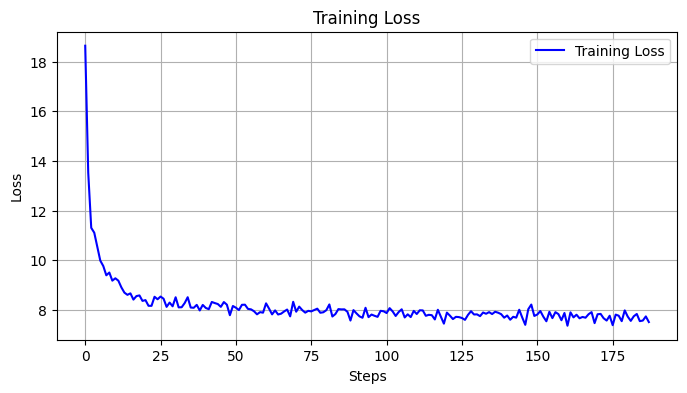

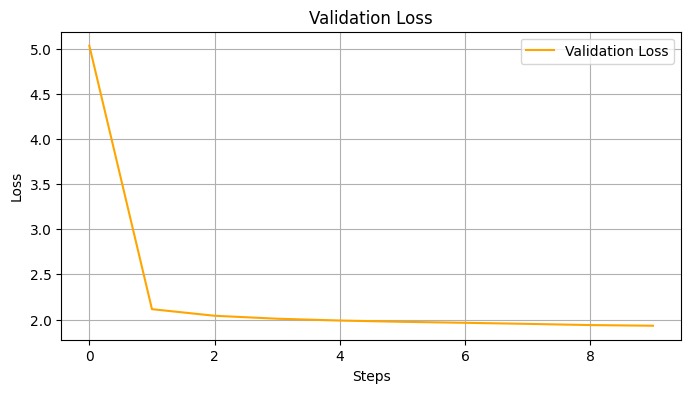

In [ ]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

train_losses = [log['loss'] for log in log_history if 'loss' in log]
val_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]

plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
trainer.model.push_to_hub("gemma2-2b-it-persian-p-tuned")

adapter_model.safetensors:   0%|          | 0.00/184k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AliHamzeh/gemma2-2b-it-persian-p-tuned/commit/a16f37056748be51d55028069787d99dba305bea', commit_message='Upload model', commit_description='', oid='a16f37056748be51d55028069787d99dba305bea', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AliHamzeh/gemma2-2b-it-persian-p-tuned', endpoint='https://huggingface.co', repo_type='model', repo_id='AliHamzeh/gemma2-2b-it-persian-p-tuned'), pr_revision=None, pr_num=None)

### Testing

In [ ]:
!git clone https://huggingface.co/AliHamzeh/gemma2-2b-it-persian-p-tuned

In [ ]:
trained_model = PeftModel.from_pretrained(model, "./gemma2-2b-it-persian-p-tuned", is_trainable=False)

In [ ]:
messages = [
    {"role": "user", "content": " سلام. تو کی هستی؟"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(trained_model, input_ids, cache=False)

user
 سلام. تو کی هستی؟
assistant
سلام. من یک دستیار هوش مصنوعی هستم که توسط گوگل آموزش دیده‌ام.



In [ ]:
messages = [
    {"role": "user", "content": "یک شعر راجع به فصل بهار بگو."},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(trained_model, input_ids, cache=False)

c:\Users\ALI\AppData\Local\Programs\Python\Python310\lib\site-packages\peft\peft_model.py:1686: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")


user
یک شعر راجع به فصل بهار بگو.
assistant
در پاییز، برگ‌ها زرد و قرمز می‌شوند،
در زمستان، برف روی زمین می‌بارد،
در بهار، زندگی دوباره می‌آید،
با گل‌های رنگارنگ و درختان بلند.

در بهار، هوا گرم می‌شود،
گل‌ها شکوفا می‌شوند،
و حیوانات از خواب بیدار می‌شوند،
زندگی دوباره شروع می‌شود.

در بهار، من احساس خوشحالی می‌کنم،
زیرا همه چیز در حال رشد است،
و من می‌توانم با اطمینان بگوییم،
که بهار بهترین فصل است.



In [ ]:
messages = [
    {"role": "user", "content": "یک جوک بهم بگو"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(trained_model, input_ids, cache=False)

user
یک جوک بهم بگو
why don't scientists trust atoms?

because they make up everything!



In [ ]:
messages = [
    {"role": "system", "content": "شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ مفصل و طولانی تولید کنید."},
    {"role": "user", "content": "در خرید کفش باید به چه نکاتی دقت کنیم؟"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(trained_model, input_ids, cache=False)

system
شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ مفصل و طولانی تولید کنید.
user
در خرید کفش باید به چه نکاتی دقت کنیم؟
assistant
هنگام خرید کفش، چند نکته حیاتی وجود دارد که باید در نظر بگیرید تا مطمئن شوید که انتخاب شما بهترین گزینه برای نیازهای شما است. این نکات شامل موارد زیر است:

1. اندازه‌گیری صحیح: قبل از رفتن به فروشگاه، اندازه‌گیری دقیق پا خود را انجام دهید. اندازه پا می‌تواند متفاوت باشد، بنابراین اطمینان حاصل کنید که کفش‌هایی را که می‌خواهید امتحان کنید، با اندازه‌گیری‌های قبلی خود تطبیق می‌دهند. بسیاری از فروشگاه‌ها ابزار اندازه‌گیری پا ارائه می‌دهند، اما اگر آنها آن را ندارند، می‌توانید از یک متر یا کاغذ و مداد برای اندازه‌گیری خود استفاده کنید.

2. نوع کفش مورد نیاز: متوجه شوید که کدام نوع کفش برای نیازهای شما مناسب‌تر است. برخی از رایج‌ترین انواع کفش عبارتند از:
    - کفش ورزشی: برای فعالیت‌های فیزیکی مانند دویدن، شنا، پیاده‌روی و غیره.
    - کفش مجلسی: برای مهمانی‌ها، عروسی‌ها و دیگر مناسبت‌های رسمی.
    - کفش اداری: برای محیط کار و 

In [ ]:
messages = [
    {"role": "user", "content": "یک داستان کوتاه در مورد یک مسافر و یک شتر بنویس."},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(trained_model, input_ids, cache=False, max_new_tokens=256)

user
یک داستان کوتاه در مورد یک مسافر و یک شتر بنویس.
با توجه به تعریف زیر، یک داستان کوتاه در مورد یک مسافر و یک شتر بنویسید:

شخصیت‌ها:
1. فردی با نام مستعار "جرمی"
2. یک شتر با نام "آلفرد"

داستان:
جرمی، مردی با ظاهری عجیب و غریب و لباس‌های رنگارنگ پوشیده شده بود که هرگز کسی را ندیده بود. او به دنبال چیزی بود که نمی‌دانست چه چیزی است، اما می‌دانست که باید آن را پیدا کند. پس از گذراندن روزها و شب‌ها در جاده‌های خاکی و بیابانی، جرمی ناگهان متوجه شد که آلفرد، یک شتر با موهای خاکستری بلند و چشم‌های آبی تیره، در کنارش ایستاده است. این شتر مانند هیچ شتر دیگری که قبلاً دیده بود، آرام و مهربان به نظر می‌رسید. جرمی به آلفرد سلام کرد و گفت: "آلفرد، آیا می‌توانی من را به جایی که می‌خواهم بروم ببری؟" آلفرد با سرعتی بی‌نظیر حرکت کرد و جرمی را به سمت یک


In [ ]:
messages = [
    {"role": "user", "content": "این جمله رو از نظر قواعد تصحیح کن: من به خانه مادرم رفت و او برایم غذا درست کردید"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(trained_model, input_ids, cache=False)

user
این جمله رو از نظر قواعد تصحیح کن: من به خانه مادرم رفت و او برایم غذا درست کردید
assistant
من به خانه مادرم رفتم و او برایم غذا درست کرد.



In [ ]:
messages = [
    {"role": "user", "content": "اگر سارا 10 سیب داشته باشد و علی 2 سیب از او بگیرد، چند سیب برای سارا باقی می‌ماند؟"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(trained_model, input_ids, cache=False)

user
اگر سارا 10 سیب داشته باشد و علی 2 سیب از او بگیرد، چند سیب برای سارا باقی می‌ماند؟
assistant
برای حل این مسئله، باید سیب‌های سارا را از سیب‌های علی کم کنیم.

سارا: 10 سیب
علی: 2 سیب
کل سیب‌ها: 10 - 2 = 8 سیب

بنابراین، سارا 8 سیب باقی می‌ماند.



In [ ]:
CONTENT = """
منظور شاعر از این بیت چیست
هرگز وجود حاضر غایب شنیده‌ای؟
من در میان جمع و دلم جای دیگر است
"""

messages = [
    {"role": "user", "content": CONTENT},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(trained_model, input_ids, cache=False)

user

منظور شاعر از این بیت چیست
هرگز وجود حاضر غایب شنیده‌ای؟
من در میان جمع و دلم جای دیگر است

assistant
"هرگز وجود حاضر غایب شنیده‌ای؟ من در میان جمع و دلم جای دیگر است" یک بیت شعر است که شاعر احساساتش را درباره فقدان و تنهایی بیان می‌کند. 

در این بیت، شاعر با سوال "هرگز وجود حاضر غایب شنیده‌ای؟" شروع می‌کند. این سوال نشان می‌دهد که شاعر به دنبال پاسخ است که آیا کسی او را می‌شناسد یا متوجه او شده است. 

او سپس اضافه می‌کند: "من در میان جمع و دلم جای دیگر است." این جمله بیان می‌کند که شاعر در وسط جمعی قرار دارد اما احساس می‌کند که جدا و تنها است. او احساس می‌کند که نمی‌تواند به راحتی با دیگران ارتباط برقرار کند و دلش جای دیگری است.

این بیت نشان می‌دهد که شاعر ممکن است غمگین، ناامید یا خشمگین باشد. او ممکن است احساس کند که کسی او را نمی‌شناسد یا به او توجهی نمی‌کند. او همچنین ممکن است احساس کند که بخشی از اجتماع نیست و احساس تنهایی دارد.



In [ ]:
messages = [
    {"role": "system", "content": "شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ مفصل و طولانی تولید کنید."},
    {"role": "user", "content": "بزرگترین حسرت های آدمی چی هستند؟"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(trained_model, input_ids, cache=False)

system
شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ مفصل و طولانی تولید کنید.
user
بزرگترین حسرت های آدمی چی هستند؟

assistant
حسرت‌ها، احساسات ناخواسته‌ای هستند که در ذهن ما شکل می‌گیرند و اغلب به چیزهایی مربوط می‌شوند که آرزو می‌کنیم داشته باشیم یا چیزی را که نداریم را تصور می‌کنیم. بزرگ‌ترین حسرت‌های آدمی می‌تواند متفاوت باشد، اما برخی از رایج‌ترین آنها عبارتند از:

1. شادی و خوشبختی دائمی: بسیاری از انسان‌ها به دنبال شادی و خوشبختی دائمی هستند، حتی اگر این شادی و خوشبختی برای همیشه وجود نداشته باشد. این حسرت‌ها ممکن است به دلیل فقدان partner مناسب، عدم موفقیت در کار یا مشکلات خانوادگی ایجاد شوند.

2. پول و ثروت بی‌نهایت: داشتن پول و ثروت بی‌نهایت یکی دیگر از بزرگ‌ترین حسرت‌های آدمی است. این حسرت‌ها ممکن است به دلیل ناکامی در کسب درآمد، بدهی‌های سنگین یا شرایط اقتصادی نامناسب ایجاد شوند.

3. سلامتی کامل و بدون درد: داشتن سلامتی کامل و بدون درد یکی دیگر از بزرگ‌ترین حسرت‌های آدمی است. این حسرت‌ها ممکن است به دلیل ابتلا به بیماری، آسیب‌دیدگی یا سایر 

In [ ]:
messages = [
    {"role": "user", "content": "بیا با هم بازی حدس عدد رو بازی کنیم"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(trained_model, input_ids, cache=False)

c:\Users\ALI\AppData\Local\Programs\Python\Python310\lib\site-packages\peft\peft_model.py:1686: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")


user
بیا با هم بازی حدس عدد رو بازی کنیم
پاسخ:
assistant
12345678910



In [ ]:
CONTENT = """
متن زیر رو به فارسی ترجمه کن:
Snakes are long, slender reptiles found all over the world except in Antarctica. They have no legs and move by slithering on the ground. Snakes come in many sizes, from tiny ones just a few inches long to giant ones like pythons that can grow over 20 feet. Most snakes are harmless to humans and help control pests by eating rodents and insects. However, some, like cobras and rattlesnakes, are venomous and use their venom to hunt or protect themselves. Snakes are fascinating creatures with unique features, like shedding their skin as they grow.
"""

messages = [
    {"role": "system", "content": "شما یک دستیار هوش مصنوعی هستید که در ترجمه انگلیسی به فارسی حرفه ای است."},
    {"role": "user", "content": CONTENT},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(trained_model, input_ids, cache=False)

system
شما یک دستیار هوش مصنوعی هستید که در ترجمه انگلیسی به فارسی حرفه ای است.
user

متن زیر رو به فارسی ترجمه کن:
Snakes are long, slender reptiles found all over the world except in Antarctica. They have no legs and move by slithering on the ground. Snakes come in many sizes, from tiny ones just a few inches long to giant ones like pythons that can grow over 20 feet. Most snakes are harmless to humans and help control pests by eating rodents and insects. However, some, like cobras and rattlesnakes, are venomous and use their venom to hunt or protect themselves. Snakes are fascinating creatures with unique features, like shedding their skin as they grow.

assistant
سنجاب‌ها جانورهای سطلی هستند که در سراسر جهان یافت می‌شوند مگر اینکه در قطب جنوب باشند. آنها هیچ پا ندارند و با حرکت بر روی زمین، مانند سنجاب‌ها، راه می‌روند. سنجاب‌ها در اندازه‌های مختلفی یافت می‌شوند، از سنجاب‌های بسیار کوچک که فقط چند اینچ طول دارند تا سنجاب‌های بزرگ مانند پیتون‌ها که می‌توانند بیش از 20 فوت طول داشته ب

In [ ]:
CONTENT = """
آبشار نیاگارا یکی از معروف‌ترین و پربازدیدترین جاذبه‌های طبیعی در جهان است که در مرز بین کانادا و ایالات متحده قرار دارد. این آبشار شامل سه بخش اصلی است: آبشار نعل اسب، آبشار آمریکایی، و آبشار نقاب عروس. آبشار نعل اسب بزرگ‌ترین و مشهورترین بخش آن است که در سمت کانادا واقع شده. هر ثانیه میلیون‌ها لیتر آب از این آبشارها عبور می‌کند که باعث تولید مقدار زیادی انرژی هیدروالکتریکی نیز می‌شود. این منطقه نه تنها برای مناظر زیبا و قدرت طبیعی‌اش، بلکه به عنوان منبع انرژی نیز اهمیت زیادی دارد.

برحسب متن بگو آبشار نیاگارا کجا قرار دارد؟
"""

messages = [
    {"role": "user", "content": CONTENT},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(trained_model, input_ids, cache=False)

user

آبشار نیاگارا یکی از معروف‌ترین و پربازدیدترین جاذبه‌های طبیعی در جهان است که در مرز بین کانادا و ایالات متحده قرار دارد. این آبشار شامل سه بخش اصلی است: آبشار نعل اسب، آبشار آمریکایی، و آبشار نقاب عروس. آبشار نعل اسب بزرگ‌ترین و مشهورترین بخش آن است که در سمت کانادا واقع شده. هر ثانیه میلیون‌ها لیتر آب از این آبشارها عبور می‌کند که باعث تولید مقدار زیادی انرژی هیدروالکتریکی نیز می‌شود. این منطقه نه تنها برای مناظر زیبا و قدرت طبیعی‌اش، بلکه به عنوان منبع انرژی نیز اهمیت زیادی دارد.

برحسب متن بگو آبشار نیاگارا کجا قرار دارد؟

assistant
آبشار نیاگارا در مرز بین کانادا و ایالات متحده قرار دارد.



In [ ]:
CONTENT = """

رمان "ماجراهای شرلوک هلمز" مجموعه‌ای از داستان‌های کوتاه نوشته آرتور کانن دویل است که برای اولین بار در سال 1892 منتشر شد. آگاتا کریستی نویسنده داستان‌های جنایی مشهوری مانند "قتل در قطار سریع‌السیر شرق" و "ده نفر کوچک" بوده است و در زمان انتشار "ماجراهای شرلوک هلمز" تنها دو سال داشت.
 تعیین کنید آیا جمله بر اساس متن زیر درست است یا نه
آرتور کانن دویل رمان "ماجراهای شرلوک هلمز" را با همکاری آگاتا کریستی نوشته است.
گزینه‌ها: 1. بله 2. نمی‌توان گفت 3. خیر

"""

messages = [
    {"role": "system", "content": "شما یک دستیار هوش مصنوعی هستید. در حین انجام وظیفه، مرحله به مرحله فکر کنید و مراحل خود را توجیه کنید تا به جواب درست برسید.."},
    {"role": "user", "content": CONTENT},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(trained_model, input_ids, cache=False, max_new_tokens=1000)

system
شما یک دستیار هوش مصنوعی هستید. در حین انجام وظیفه، مرحله به مرحله فکر کنید و مراحل خود را توجیه کنید تا به جواب درست برسید..
user


رمان "ماجراهای شرلوک هلمز" مجموعه‌ای از داستان‌های کوتاه نوشته آرتور کانن دویل است که برای اولین بار در سال 1892 منتشر شد. آگاتا کریستی نویسنده داستان‌های جنایی مشهوری مانند "قتل در قطار سریع‌السیر شرق" و "ده نفر کوچک" بوده است و در زمان انتشار "ماجراهای شرلوک هلمز" تنها دو سال داشت.
 تعیین کنید آیا جمله بر اساس متن زیر درست است یا نه
آرتور کانن دویل رمان "ماجراهای شرلوک هلمز" را با همکاری آگاتا کریستی نوشته است.
گزینه‌ها: 1. بله 2. نمی‌توان گفت 3. خیر


assistant
1. بله



## QLoRA

### Preperation

In [ ]:
peft_model = prepare_model_for_kbit_training(model)

In [ ]:
from peft import LoHaConfig, get_peft_model

peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.01,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

peft_model = get_peft_model(model, peft_config)

In [ ]:
peft_model.print_trainable_parameters()

trainable params: 10,383,360 || all params: 2,624,725,248 || trainable%: 0.3956


In [ ]:
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")
    else:
        print(f"Frozen: {name}")

Frozen: base_model.model.model.embed_tokens.weight
Frozen: base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight
Trainable: base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight
Trainable: base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight
Frozen: base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight
Trainable: base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight
Trainable: base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight
Frozen: base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight
Trainable: base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight
Trainable: base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight
Frozen: base_model.model.model.layers.0.self_attn.o_proj.base_layer.weight
Trainable: base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight
Trainable: base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.

### Training

In [ ]:
training_args = SFTConfig(
        output_dir="./gemma_qlora_final",
        num_train_epochs=1,                     
        per_device_train_batch_size=2,          
        gradient_accumulation_steps=4,          
        max_seq_length=1024,
        optim="adamw_bnb_8bit",              
        learning_rate=2e-4,                     
        lr_scheduler_type="constant",   
        warmup_ratio=0.03,                  
        logging_steps=10, 
        save_steps=200,                      
        save_strategy="steps",                  
        bf16=False,                              
        fp16=True,                             
        max_grad_norm=0.3,                      
        gradient_checkpointing=True,            
        packing=True,     
        disable_tqdm=False,
        report_to='none',
        dataset_kwargs={
            "add_special_tokens": False, # We template with special tokens
            "append_concat_token": False, # No need to add additional separator token
        },           
           
    )

trainer = SFTTrainer(
    model=peft_model,
    processing_class=tokenizer,
    train_dataset=dataset,    
    args=training_args,  
    
    peft_config=peft_config
)

peft_model.config.use_cache = False
trainer.train()

Generating train split: 0 examples [00:00, ? examples/s]

Step,Training Loss
10,10.604100
20,8.676800
30,7.935500
40,7.839900
50,7.408300
60,7.150600
70,7.304000
80,7.290500
90,7.242800
100,6.942000


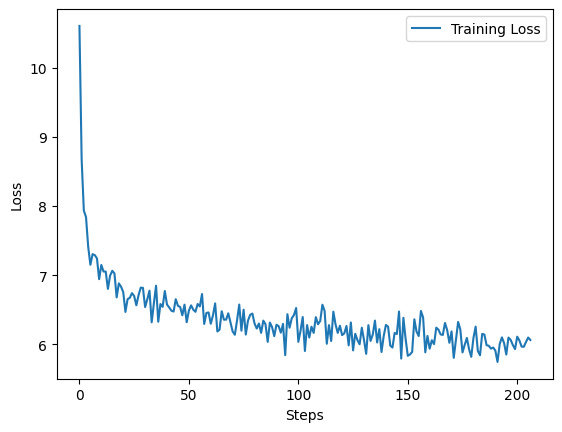

In [ ]:
import matplotlib.pyplot as plt


log_history = trainer.state.log_history

train_losses = [log['loss'] for log in log_history if 'loss' in log]

plt.plot(train_losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
trainer.model.push_to_hub("gemma2-2b-it-qlora-persian-finetuned")


adapter_model.safetensors:   0%|          | 0.00/41.6M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AliHamzeh/gemma2-2b-it-qlora-persian-finetuned/commit/33188d0e56c00c2aeeb04c50f140200be8495efa', commit_message='Upload model', commit_description='', oid='33188d0e56c00c2aeeb04c50f140200be8495efa', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AliHamzeh/gemma2-2b-it-qlora-persian-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='AliHamzeh/gemma2-2b-it-qlora-persian-finetuned'), pr_revision=None, pr_num=None)

### Testing

In [ ]:
TOKENIZER_ID = "philschmid/gemma-tokenizer-chatml"
MODEL_ID = "AliHamzeh/gemma2-2b-it-qlora-persian-finetuned"

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_ID)
tokenizer.padding_side = 'right'

bnb_config = BitsAndBytesConfig(
    load_in_4bit= True,
    bnb_4bit_quant_type= "nf4",
    bnb_4bit_compute_dtype= torch.float16,
    bnb_4bit_use_double_quant= False,
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    device_map="auto",
    #torch_dtype=torch.bfloat16,
    quantization_config= bnb_config,
    attn_implementation='eager'
)

In [ ]:
messages = [
    {"role": "user", "content": " سلام. تو کی هستی؟"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
 سلام. تو کی هستی؟
assistant
سلام! من یک دستیار هوش مصنوعی هستم که به شما کمک می‌کنم تا وظایف انجام دهید و پاسخ‌های مفیدی ارائه دهم. چگونه می‌توانم به شما کمک کنم؟



In [ ]:
messages = [
    {"role": "user", "content": "یک شعر راجع به فصل بهار بگو."},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
یک شعر راجع به فصل بهار بگو.
assistant
فصل بهار در حال آمدن است،
نور خورشید بر روی زمین می‌تابد.
گل‌های زیبا و رنگارنگ،
در باغ‌ها و مزارع شکوفا می‌شوند.

بادهای ملایم نوازش می‌کنند،
سایه‌های نازک بر روی برگ‌ها می‌نشینند.
پرندگان خوش‌آمد می‌گویند،
در آسمان پرندگان آواز می‌خوانند.

زمستان فراموش شده است،
و طبیعت دوباره زنده می‌شود.
با لبخند و شادی،
فصل بهار آغاز می‌شود.



In [ ]:
messages = [
    {"role": "user", "content": "یک جوک بهم بگو"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids, max_new_tokens=256)

user
یک جوک بهم بگو
assistant
جوک: چرا سگ‌ها نمی‌توانند آب‌نبات بخورند؟

پاسخ: چون دندان‌های کوچکی ندارند!



In [ ]:
messages = [
    {"role": "system", "content": "شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ مفصل و طولانی تولید کنید."},
    {"role": "user", "content": "در خرید کفش باید به چه نکاتی دقت کنیم؟"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

system
شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ مفصل و طولانی تولید کنید.
user
در خرید کفش باید به چه نکاتی دقت کنیم؟
assistant
هنگام خرید کفش، چندین نکته کلیدی وجود دارد که باید در نظر بگیرید تا اطمینان حاصل کنید که کفش مناسب شما انتخاب شده است. این نکات شامل موارد زیر است:

1. اندازه‌گیری پاها: قبل از خرید کفش، اندازه‌گیری دقیق پاهای خود را انجام دهید تا مطمئن شوید که کفش‌ها به اندازه کافی فضای کافی برای رشد پاها دارند. اندازه‌گیری پاها معمولاً با استفاده از یک نوار اندازه‌گیری یا سنجاق اندازه‌گیری انجام می‌شود.

2. نوع کفش را انتخاب کنید: بسته به فعالیت‌هایی که می‌خواهید کفش‌های خود را برای آن‌ها استفاده کنید، انواع مختلفی از کفش‌ها وجود دارد. برخی از رایج‌ترین انواع عبارتند از:

   الف. کفش‌های ورزشی: کفش‌های ورزشی برای فعالیت‌های بدنی مانند دویدن، پیاده‌روی و شنا طراحی شده‌اند. این کفش‌ها معمولاً عریض‌تر، سبک‌تر و راحت‌تر از کفش‌های غیرورزشی هستند.

   ب. کفش‌های رسمی: کفش‌های رسمی برای استفاده در محیط‌های رسمی مانند جلسات کاری، کنفرانس‌ها و 

In [ ]:
messages = [
    {"role": "system", "content": "شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ مفصل و طولانی تولید کنید."},
    {"role": "user", "content": "یک داستان کوتاه در مورد یک مسافر و یک شتر بنویس."},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

system
شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ مفصل و طولانی تولید کنید.
user
یک داستان کوتاه در مورد یک مسافر و یک شتر بنویس.
assistant
عنوان: پیاده‌روی با شتر

روزی روزگاری، در جایی که کوه‌ها به آسمان می‌پیچیدند و رودخانه‌ها از صخره‌ها عبور می‌کردند، مردی به نام اریک زندگی می‌کرد. اریک عاشق طبیعت بود و هر فرصتی برای لذت بردن از زیبایی‌های اطرافش پیدا می‌کرد. یکی از چیزهای مورد علاقه‌اش، سفر با شتر بود.

یک روز، اریک تصمیم گرفت سفری با شتر بگذراند. او یک شتر جوان و پرانرژی را انتخاب کرد که بسیار مهربان و دوست‌داشتنی بود. پس از رسیدن به محل اقامتشان، اریک شروع به آماده‌سازی برای سفر کرد. او وسایل لازم را جمع‌آوری کرد، از جمله چادر، ملزومات پزشکی، غذا و نوشیدنی.

پس از اینکه همه چیز آماده شد، اریک و شتر وارد جاده‌ای زیبا شدند که از میان جنگل‌های سرسبز و بیابان‌های وسیع عبور می‌کرد. اریک متوجه شد که شتر نه تنها سریع است، بلکه بسیار پایدار و قابل اعتماد نیز می‌باشد.

با گذشت روزها، اریک و شتر نزدیک‌تر شدند


In [ ]:
messages = [
    {"role": "user", "content": "این جمله رو از نظر قواعد تصحیح کن: من به خانه مادرم رفت و او برایم غذا درست کردید"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
این جمله رو از نظر قواعد تصحیح کن: من به خانه مادرم رفت و او برایم غذا درست کردید
assistant
من به خانه مادرم رفتم و او برایم غذا درست کرد.



In [ ]:
messages = [
    {"role": "user", "content": "این جمله رو از نظر قواعد تصحیح کن و توضیح بده مشکل چی بوده و چجوری درست شده: من به خانه مادرم رفت و او برایم غذا درست کردید"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


user
این جمله رو از نظر قواعد تصحیح کن و توضیح بده مشکل چی بوده و چجوری درست شده: من به خانه مادرم رفت و او برایم غذا درست کردید
assistant
من به خانه مادرم رفتم و او برایم غذا درست کرد.

مشکل اصلی در این جمله این بود که "برایم" باید قبل از "غذا درست کرد" قرار می‌گرفت تا نشان دهد گوینده غذای درست شده را دریافت کرده است. با اضافه کردن "برایم"، جمله به درستی معنی را منتقل می‌کند.



In [ ]:
messages = [
    {"role": "user", "content": "اگر سارا 10 سیب داشته باشد و علی 2 سیب از او بگیرد، چند سیب برای سارا باقی می‌ماند؟"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
اگر سارا 10 سیب داشته باشد و علی 2 سیب از او بگیرد، چند سیب برای سارا باقی می‌ماند؟
assistant
اگر سارا 10 سیب داشته باشد و علی 2 سیب از او بگیرد، برای سارا 10 - 2 = 8 سیب باقی می‌ماند.



In [ ]:
CONTENT = """
منظور شاعر از این بیت چیست
هرگز وجود حاضر غایب شنیده‌ای؟
من در میان جمع و دلم جای دیگر است
"""

messages = [
    {"role": "user", "content": CONTENT},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids, max_new_tokens = 1000)

user

منظور شاعر از این بیت چیست
هرگز وجود حاضر غایب شنیده‌ای؟
من در میان جمع و دلم جای دیگر است

assistant
برای درک منظور شاعر از این بیت، بیایید هر جمله را به صورت جداگانه تحلیل کنیم:

1. "هرگز وجود حاضر غایب شنیده‌ای؟"
این جمله نشان‌دهنده ناامیدی یا نارضایتی شاعر از وضعیت فعلی اوست. او ممکن است احساس کند که هیچ‌کس نمی‌داند یا توجهی به او نمی‌کند.

2. "من در میان جمع و دلم جای دیگر است"
این جمله نشان می‌دهد که شاعر در یک محیط اجتماعی یا جمعی احساس راحتی نمی‌کند. او ممکن است احساس کند که نادیده گرفته شده یا مورد تمسخر قرار گرفته است.

با ترکیب این دو جمله، می‌توانیم نتیجه بگیریم که منظور شاعر از این بیت نگرانی خود را از نادیده گرفتن یا تمسخر شدن ابراز می‌کند. او ممکن است احساس کند که در میان افرادی که اطرافش هستند، جایی برای خود ندارد و این موضوع او را ناراحت یا ناامید می‌کند.



In [ ]:
messages = [
    {"role": "user", "content": "بزرگترین حسرت های آدمی چی هستند؟"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
بزرگترین حسرت های آدمی چی هستند؟
assistant
بزرگترین حسرت‌های آدمی می‌تواند بسته به سن، شخصیت و تجربه‌های شخصی فرد متفاوت باشد. با این حال، برخی از رایج‌ترین حسرت‌ها عبارتند از:

1. **حسرت برای زمان بیشتر:** بسیاری از مردم آرزو می‌کنند که زمان بیشتری برای انجام کارهای مورد علاقه‌شان، گذراندن وقت با عزیزانشان و لذت بردن از تجربیات جدید داشته باشند.

2. **حسرت برای سلامتی بهتر:** افراد ممکن است آرزو کنند که وضعیت سلامتی‌شان بهبود یابد و بتوانند فعالیت‌های جسمانی را بدون درد یا ناراحتی انجام دهند.

3. **حسرت برای ثروت بیشتر:** برخی افراد ممکن است آرزو کنند که ثروت بیشتری داشته باشند تا بتوانند نیازها و خواسته‌های خود را برآورده کنند و به دیگران کمک کنند.

4. **حسرت برای روابط عمیق‌تر:** بسیاری از افراد ممکن است آرزو کنند که روابط عمیق‌تری با خانواده، دوستان یا شریک زندگی‌شان داشته باشند.

5. **حسرت برای فرصت‌هایی که از دست داده‌اند:** افراد ممکن است آرزو کنند که فرصت‌هایی را که از دست داده‌اند، دوباره داشته باشند


In [ ]:
messages = [
    {"role": "user", "content": "بیا با هم بازی حدس عدد رو بازی کنیم"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
بیا با هم بازی حدس عدد رو بازی کنیم
assistant
خب، دوست کوچولوی من، بیایید بازی حدس عدد رو انجام دهیم! این کار خیلی سرگرم‌کننده است و ما می‌توانیم مهارت‌های ریاضی‌مان را به کار ببریم.

برای شروع، می‌خواهم از تو بخواهم که یک عدد بین 1 تا 100 انتخاب کنی. بعد از اینکه عدد را انتخاب کردی، می‌خواهم از تو بخواهم که حدس بزنم این عدد چه مقدار است.

پس، دوست کوچولوی من، کدام عدد را انتخاب می‌کنی؟



In [ ]:
CONTENT = """
متن زیر رو به فارسی ترجمه کن:
Snakes are long, slender reptiles found all over the world except in Antarctica. They have no legs and move by slithering on the ground. Snakes come in many sizes, from tiny ones just a few inches long to giant ones like pythons that can grow over 20 feet. Most snakes are harmless to humans and help control pests by eating rodents and insects. However, some, like cobras and rattlesnakes, are venomous and use their venom to hunt or protect themselves. Snakes are fascinating creatures with unique features, like shedding their skin as they grow.
"""

messages = [
    {"role": "system", "content": "شما یک دستیار هوش مصنوعی هستید که در ترجمه انگلیسی به فارسی حرفه ای است."},
    {"role": "user", "content": CONTENT},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

system
شما یک دستیار هوش مصنوعی هستید که در ترجمه انگلیسی به فارسی حرفه ای است.
user

متن زیر رو به فارسی ترجمه کن:
Snakes are long, slender reptiles found all over the world except in Antarctica. They have no legs and move by slithering on the ground. Snakes come in many sizes, from tiny ones just a few inches long to giant ones like pythons that can grow over 20 feet. Most snakes are harmless to humans and help control pests by eating rodents and insects. However, some, like cobras and rattlesnakes, are venomous and use their venom to hunt or protect themselves. Snakes are fascinating creatures with unique features, like shedding their skin as they grow.

assistant
سنجاب‌ها از خزندگان بلند و باریک هستند که در سرتاسر جهان زندگی می‌کنند مگر اینکه در قطب جنوب باشند. آنها پاهای ندارند و بر روی زمین حرکت می‌کنند. سنجاب‌ها در اندازه‌های متفاوتی وجود دارند، از سنجاب‌های کوچک فقط چند اینچ طول تا سنجاب‌های بزرگ مانند پیتون‌هایی که می‌توانند بیش از 20 فوت رشد کنند. بیشتر سنجاب‌ها بی‌خطر برای ا

In [ ]:
CONTENT = """
آبشار نیاگارا یکی از معروف‌ترین و پربازدیدترین جاذبه‌های طبیعی در جهان است که در مرز بین کانادا و ایالات متحده قرار دارد. این آبشار شامل سه بخش اصلی است: آبشار نعل اسب، آبشار آمریکایی، و آبشار نقاب عروس. آبشار نعل اسب بزرگ‌ترین و مشهورترین بخش آن است که در سمت کانادا واقع شده. هر ثانیه میلیون‌ها لیتر آب از این آبشارها عبور می‌کند که باعث تولید مقدار زیادی انرژی هیدروالکتریکی نیز می‌شود. این منطقه نه تنها برای مناظر زیبا و قدرت طبیعی‌اش، بلکه به عنوان منبع انرژی نیز اهمیت زیادی دارد.

برحسب متن بگو آبشار نیاگارا کجا قرار دارد؟
"""

messages = [
    {"role": "user", "content": CONTENT},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user

آبشار نیاگارا یکی از معروف‌ترین و پربازدیدترین جاذبه‌های طبیعی در جهان است که در مرز بین کانادا و ایالات متحده قرار دارد. این آبشار شامل سه بخش اصلی است: آبشار نعل اسب، آبشار آمریکایی، و آبشار نقاب عروس. آبشار نعل اسب بزرگ‌ترین و مشهورترین بخش آن است که در سمت کانادا واقع شده. هر ثانیه میلیون‌ها لیتر آب از این آبشارها عبور می‌کند که باعث تولید مقدار زیادی انرژی هیدروالکتریکی نیز می‌شود. این منطقه نه تنها برای مناظر زیبا و قدرت طبیعی‌اش، بلکه به عنوان منبع انرژی نیز اهمیت زیادی دارد.

برحسب متن بگو آبشار نیاگارا کجا قرار دارد؟

assistant
آبشار نیاگارا در مرز بین کانادا و ایالات متحده قرار دارد.



In [ ]:
CONTENT = """

رمان "ماجراهای شرلوک هلمز" مجموعه‌ای از داستان‌های کوتاه نوشته آرتور کانن دویل است که برای اولین بار در سال 1892 منتشر شد. آگاتا کریستی نویسنده داستان‌های جنایی مشهوری مانند "قتل در قطار سریع‌السیر شرق" و "ده نفر کوچک" بوده است و در زمان انتشار "ماجراهای شرلوک هلمز" تنها دو سال داشت.
 تعیین کنید آیا جمله بر اساس متن زیر درست است یا نه
آرتور کانن دویل رمان "ماجراهای شرلوک هلمز" را با همکاری آگاتا کریستی نوشته است.
گزینه‌ها: 1. بله 2. نمی‌توان گفت 3. خیر

"""

messages = [
    {"role": "system", "content": "شما یک دستیار هوش مصنوعی هستید. در حین انجام وظیفه، مرحله به مرحله فکر کنید و مراحل خود را توجیه کنید تا به جواب درست برسید.."},
    {"role": "user", "content": CONTENT},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids, max_new_tokens=1000)

system
شما یک دستیار هوش مصنوعی هستید. در حین انجام وظیفه، مرحله به مرحله فکر کنید و مراحل خود را توجیه کنید تا به جواب درست برسید..
user


رمان "ماجراهای شرلوک هلمز" مجموعه‌ای از داستان‌های کوتاه نوشته آرتور کانن دویل است که برای اولین بار در سال 1892 منتشر شد. آگاتا کریستی نویسنده داستان‌های جنایی مشهوری مانند "قتل در قطار سریع‌السیر شرق" و "ده نفر کوچک" بوده است و در زمان انتشار "ماجراهای شرلوک هلمز" تنها دو سال داشت.
 تعیین کنید آیا جمله بر اساس متن زیر درست است یا نه
آرتور کانن دویل رمان "ماجراهای شرلوک هلمز" را با همکاری آگاتا کریستی نوشته است.
گزینه‌ها: 1. بله 2. نمی‌توان گفت 3. خیر


assistant
مرحله 1: اطلاعات کلیدی موجود در متن را شناسایی کنید.
- آرتور کانن دویل رمان "ماجراهای شرلوک هلمز" را نوشته است.
- آگاتا کریستی نویسنده داستان‌های جنایی مشهور دیگری مانند "قتل در قطار سریع‌السیر شرق" و "ده نفر کوچک" بوده است.

مرحله 2: اطلاعات کلیدی را با جمله داده شده مقایسه کنید.
- جمله می‌گوید: "آرتور کانن دویل رمان 'ماجراهای شرلوک هلمز' را با همکاری آگاتا کریستی نوشته است."

مرحله 3: ا

## Traditional Fine-tuning(First and Last Layers)

### Preparation

In [ ]:
TOKENIZER_ID = "philschmid/gemma-tokenizer-chatml"
MODEL_ID = "AliHamzeh/gemma2-2b-it-qlora-persian-finetuned"

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_ID)
tokenizer.padding_side = 'right'

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    device_map="auto",
    #torch_dtype=torch.bfloat16,
    attn_implementation='eager'
)

In [ ]:
model

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=

In [ ]:
for name, param in model.named_parameters():
    if "embed_token" in name or "lm_head" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
for name, param in model.lm_head.named_parameters():
    param.requires_grad = True
    print(name, param.requires_grad)

weight True


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")
    else:
        print(f"Frozen: {name}")

Trainable: model.embed_tokens.weight
Frozen: model.layers.0.self_attn.q_proj.weight
Frozen: model.layers.0.self_attn.k_proj.weight
Frozen: model.layers.0.self_attn.v_proj.weight
Frozen: model.layers.0.self_attn.o_proj.weight
Frozen: model.layers.0.mlp.gate_proj.weight
Frozen: model.layers.0.mlp.up_proj.weight
Frozen: model.layers.0.mlp.down_proj.weight
Frozen: model.layers.0.input_layernorm.weight
Frozen: model.layers.0.post_attention_layernorm.weight
Frozen: model.layers.0.pre_feedforward_layernorm.weight
Frozen: model.layers.0.post_feedforward_layernorm.weight
Frozen: model.layers.1.self_attn.q_proj.weight
Frozen: model.layers.1.self_attn.k_proj.weight
Frozen: model.layers.1.self_attn.v_proj.weight
Frozen: model.layers.1.self_attn.o_proj.weight
Frozen: model.layers.1.mlp.gate_proj.weight
Frozen: model.layers.1.mlp.up_proj.weight
Frozen: model.layers.1.mlp.down_proj.weight
Frozen: model.layers.1.input_layernorm.weight
Frozen: model.layers.1.post_attention_layernorm.weight
Frozen: mode

In [ ]:
train_sample = dataset.select(range(8000))
train_sample

Dataset({
    features: ['messages'],
    num_rows: 8000
})

In [ ]:
!export 'PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True'

In [ ]:
training_args = SFTConfig(
    output_dir="./gemma-finetune",
    num_train_epochs=1,                     
    per_device_train_batch_size=1,          
    gradient_accumulation_steps=8,          
    max_seq_length=512,
    optim="adamw_bnb_8bit",              
    learning_rate=2e-4,                     
    lr_scheduler_type="constant",   
    warmup_ratio=0.03,                  
    logging_steps=10, 
    save_steps=200,                      
    save_strategy="steps",                  
    bf16=True,                              
    fp16=False,     
    torch_empty_cache_steps = 1,
    max_grad_norm=0.3,                      
    gradient_checkpointing=True,            
    packing=True,        
    report_to="none",
    logging_first_step=True,
    disable_tqdm=False, 
    dataset_kwargs={
        "add_special_tokens": False, 
        "append_concat_token": False, 
    },
)

trainer = SFTTrainer(
    model=model,
    processing_class=tokenizer,
    train_dataset=train_sample,    
    args=training_args,  
)


model.config.use_cache = False
trainer.train()

Generating train split: 0 examples [00:00, ? examples/s]

Step,Training Loss
1,31.390400
10,27.000300
20,24.183800
30,22.815100
40,21.373400
50,20.571800
60,20.672100
70,20.270900
80,19.670700
90,19.172200


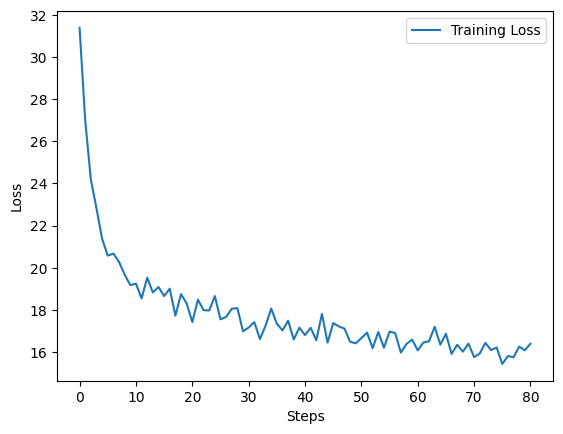

In [ ]:
import matplotlib.pyplot as plt


log_history = trainer.state.log_history

train_losses = [log['loss'] for log in log_history if 'loss' in log]

plt.plot(train_losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
trainer.model.push_to_hub("gemma2-2b-it-persian-fine-tuned")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AliHamzeh/gemma2-2b-it-persian-fine-tuned/commit/c49ba5477aa113bd4f173b35a647d8f5aa53ba84', commit_message='Upload Gemma2ForCausalLM', commit_description='', oid='c49ba5477aa113bd4f173b35a647d8f5aa53ba84', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AliHamzeh/gemma2-2b-it-persian-fine-tuned', endpoint='https://huggingface.co', repo_type='model', repo_id='AliHamzeh/gemma2-2b-it-persian-fine-tuned'), pr_revision=None, pr_num=None)

In [ ]:
messages = [
    {"role": "user", "content": " سلام. تو کی هستی؟"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
 سلام. تو کی هستی؟

سلام! من گیتا هستم، یک دستیار هوش مصنوعی که توسط گوگل آموزش داده شده‌ام. به سوالات شما پاسخ می‌دهم و به شما در انجام وظایف کمک می‌کنم.



In [ ]:
messages = [
    {"role": "user", "content": "یک شعر راجع به فصل بهار بگو."},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
یک شعر راجع به فصل بهار بگو.
 پس از زمستان سخت و دراز،
نور خورشید طلوع می‌کند،
آسمان ابریشمی رنگین‌کمان،
صحنه‌ای شگفت‌انگیز می‌سازد.

در باغ‌ها گل‌ها باز می‌کنند،
با عطر دلپذیرشان،
حیوانات لبخند می‌زنند،
و زندگی دوباره می‌خوانند.

فصل بهار، یک نعمت بی‌نظیر،
موجی از نشاط و شادی،
که قلب‌های محبوس شده را باز می‌کند،
و روح را با طوفان عشق پر می‌کند.

گزینه‌ها:
الف) بله
ب) نه

پاسخ: الف
assistant:
assistant:



In [ ]:
messages = [
    {"role": "user", "content": "یک جوک بهم بگو"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids, max_new_tokens=256)

user
یک جوک بهم بگو
که تو را خنده‌دار کند.

پاسخ: 

Why did the tomato blush in the salad? 🍅💖

Bcz it saw the salad dressing! 😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅😅


In [ ]:
messages = [
    {"role": "system", "content": "شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ مفصل و طولانی تولید کنید."},
    {"role": "user", "content": "در خرید کفش باید به چه نکاتی دقت کنیم؟"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

system
شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ مفصل و طولانی تولید کنید.
user
در خرید کفش باید به چه نکاتی دقت کنیم؟
assistant
خرید کفش می‌تواند یک تجربه هیجان‌انگیز و لذت‌بخش باشد، اما در عین حال ضروری است که نکات کلیدی را در نظر بگیریم تا اطمینان حاصل کنیم که کفش‌های خریداری شده از نظر کیفیت و تناسب اندام با نیازهای خودمان مطابقت دارند.

نکات کلیدی برای خرید کفش عبارتند از:

1. **اندازه و تناسب:** اولین نکته‌ای که باید در نظر بگیریم این است که اندازه و تناسب کفش‌ها با پاهای خودمان مطابقت داشته باشند. کفش‌هایی که به اندازه کافی بزرگ یا کوچک نیستند، ممکن است فشار زیادی به پاها وارد کنند و منجر به درد و ناهماهنگی شود.

2. **نوع کف و پاشنه:** نوع کف و پاشنه نیز یکی از نکات کلیدی است که باید در نظر بگیریم. کفش‌هایی که دارای کف سخت و پاشنه بلند هستند، ممکن است فشار زیادی به پاها وارد کنند و منجر به درد و ناهماهنگی شود.

3. **مواد تشکیل‌دهنده:** مواد تشکیل‌دهنده نیز یکی از نکات کلیدی است که باید در نظر بگیریم. کفش‌هایی که


In [ ]:
messages = [
    {"role": "user", "content": "چه ماهی از ماه های شمسی پنجمین ماه است؟"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

outputs = model.generate(**input_ids, max_new_tokens=256)
print(tokenizer.decode(outputs[0]))


<bos><|im_start|>user
چه ماهی از ماه های شمسی پنجمین ماه است؟<|im_end|>


**پاسخ:**

ماه پنجم در شمسی **فروردین** است. 
<|im_end|>


In [ ]:
messages = [
    {"role": "user", "content": "یک داستان کوتاه در مورد یک مسافر و یک شتر بنویس."},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
یک داستان کوتاه در مورد یک مسافر و یک شتر بنویس.
*پاسخی به این سوال ارائه دهید.*

در میان دشت‌های صاف و بیابان‌های سوزان، جایی وجود داشت که با طلوع آفتاب برمی‌گرفت و با غروب خورشید می‌خوابید. در اینجا، مردی به نام سیاغر زندگی می‌کرد. سیاغر تنها کسی بود که در این محله زندگی می‌کرد و هیچ‌کس نمی‌توانست او را ببیند یا بشنود. هر روز، وقتی طلوع آفتاب آغاز می‌شد، سیاغر از خانه‌اش خارج می‌شد و به سمت صحرا می‌رفت تا گوسفندهایش را جمع‌آوری کند. 

سیاغر سال‌هاست که در این محله زندگی می‌کند و هیچ‌کس نمی‌توانست او را ببیند یا بشنود. اما یکی از روزها، زمانی که سیاغر در حال جمع‌آوری گوسفندها بود، یک شتر سفید با چشمان قهوه‌ای تیره به او نگاه کرد. شتر به سرعت نزدیک شد و به سیاغر لبخند زد. سیاغر خنده‌اش را فراموش کرد و به شتر گفت: "چطور می‌خواهی بروم؟" شتر به سیاغر پاسخ داد: "


In [ ]:
messages = [
    {"role": "user", "content": "این جمله رو از نظر قواعد تصحیح کن: من به خانه مادرم رفت و او برایم غذا درست کردید"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
این جمله رو از نظر قواعد تصحیح کن: من به خانه مادرم رفت و او برایم غذا درست کردید
assistant
"من به خانه مادرم رفتم و او برایم غذا درست کرد."

در این جمله، یک اشتباه کوچک در ساختار وجود دارد که باید اصلاح شود. عبارت "و او برایم غذا درست کردید" دارای ساختار نادرست است، زیرا "برایم" در این زمینه معنای "برای من" را منتقل نمی‌کند. همچنین، استفاده از gerund "بذری" در جمله صحیح نیست. بنابراین، جمله اصلاح شده به شکل زیر است:

"من به خانه مادرم رفتم و او برایم غذا درست کرد."



In [ ]:
messages = [
    {"role": "user", "content": "اگر سارا 10 سیب داشته باشد و علی 2 سیب از او بگیرد، چند سیب برای سارا باقی می‌ماند؟"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
اگر سارا 10 سیب داشته باشد و علی 2 سیب از او بگیرد، چند سیب برای سارا باقی می‌ماند؟
assistant
برای پیدا کردن سیب‌های باقی مانده برای سارا، بیایید مراحل زیر را دنبال کنیم:

1. سارا در ابتدا 10 سیب داشت.
2. علی 2 سیب از سارا برد.
3. سیب‌های باقی مانده = سیب‌های اولیه - سیب‌های برداشته شده
4. سیب‌های باقی مانده = 10 - 2 = 8 سیب

بنابراین، برای سارا 8 سیب باقی مانده.



In [ ]:
CONTENT = """
منظور شاعر از این بیت چیست
هرگز وجود حاضر غایب شنیده‌ای؟
من در میان جمع و دلم جای دیگر است
"""

messages = [
    {"role": "user", "content": CONTENT},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids, max_new_tokens = 1000)

user

منظور شاعر از این بیت چیست
هرگز وجود حاضر غایب شنیده‌ای؟
من در میان جمع و دلم جای دیگر است

 
به نظر می‌رسد که شاعر در این بیت به یک تجربه شخصی یا ذهنی اشاره دارد. بیایید آن را تجزیه و تحلیل کنیم:

1. "هرگز وجود حاضر غایب شنیده‌ای؟": این جمله نشان می‌دهد که شاعر در حال ابراز نگرانی یا تردید درباره واقعیت‌های اطرافش است. او ممکن است معتقد باشد که چیزهایی وجود دارند که قابل مشاهده نیستند، یا اینکه واقعیت‌ها به گونه‌ای هستند که ما نمی‌توانیم آن‌ها را به‌خوبی ببینیم.

2. "من در میان جمع و دلم جای دیگر است": این جمله بیان می‌کند که شاعر در وضعیتی قرار دارد که با بقیه جمع متفاوت است. او ممکن است احساس کند که بخشی از جمع نیست، یا اینکه فردی جداگانه و منحصر به فرد است.

3. "دلم جای دیگر است": این عبارت نشان‌دهنده عدم رضایت یا نارضایتی شاعر از وضعیت فعلی خود است. او ممکن است آرزو داشته باشد که در یک مکان یا موقعیت دیگری باشد.

در کل، این بیت نشان می‌دهد که شاعر در وضعیتی قرار دارد که او را ناامید یا غم‌زده کرده است. او ممکن است حس کند که واقعیت‌های اطرافش غیرقابل مشاهده یا قابل فهم نیستند

In [ ]:
messages = [
    {"role": "assistant", "content": "شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ مفصل و طولانی تولید کنید."},
    {"role": "user", "content": "بزرگترین حسرت های آدمی چی هستند؟"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

system
شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ مفصل و طولانی تولید کنید.
user
بزرگترین حسرت های آدمی چی هستند؟
assistant
احتمالاً بزرگترین حسرت های آدمی چی نیستند، زیرا این موضوع عمدتاً بر اساس باورهای فردی و فرهنگی است. در عوض، می‌توانیم چندین دسته از حسادت‌های رایج را شناسایی کنیم:

1. **حسادت نسبت به موفقیت دیگران**: افراد ممکن است حسادت کنند که دیگران با موفقیت‌هایی مانند شغل، ثروت یا شهرت بیشتری مواجه شده‌اند. این حسادت می‌تواند منجر به افسردگی، اضطراب یا تنهایی شود.

2. **حسادت نسبت به زیبایی دیگران**: افراد ممکن است حسادت کنند که دیگران ظاهری بهتر یا جذابیت بیشتری دارند. این حسادت می‌تواند منجر به کمبود اعتماد به نفس یا تمایل به مقایسه خود با دیگران شود.

3. **حسادت نسبت به ثروت دیگران**: افراد ممکن است حسادت کنند که دیگران ثروت بیشتری دارند. این حسادت می‌تواند منجر به افسردگی، اضطراب یا تنهایی شود.

4. **حسادت نسبت به قدرت دیگران**: افراد ممکن است حسادت کنند که دیگران قدرت بیشتری دارند. این حسادت می‌تواند منجر به افسردگی، اضطراب یا تنهایی

In [ ]:
messages = [
    {"role": "user", "content": "بیا با هم بازی حدس عدد رو بازی کنیم"},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user
بیا با هم بازی حدس عدد رو بازی کنیم
در این بازی، شما یک عدد بین 1 تا 100 را انتخاب می‌کنید. سپس، من یک عدد بین 1 تا 100 را انتخاب می‌کنم. هدف شما این است که حدس کنید که آیا عدد من بیشتر یا کمتر از عددی است که شما انتخاب کرده‌اید.

برای شروع، شما باید یک عدد بین 1 تا 100 را انتخاب کنید. پس از اینکه شما یک عدد انتخاب کردید، من یک عدد بین 1 تا 100 را به شما نشان می‌دهم و شما باید ببینید آیا عدد من بیشتر یا کمتر از عددی است که شما انتخاب کرده‌اید.

حالا بیایید شروع کنیم. شما باید یک عدد بین 1 تا 100 را انتخاب کنید.
پاسخ:
assistant
مرحله 1: یک عدد بین 1 تا 100 را انتخاب کنید.
مرحله 2: من یک عدد بین 1 تا 100 را به شما نشان می‌دهم.
مرحله 3: ببینید آیا عدد من بیشتر یا کمتر از عددی است که شما انتخاب کرده‌اید.



In [ ]:
CONTENT = """
متن زیر رو به فارسی ترجمه کن:
Snakes are long, slender reptiles found all over the world except in Antarctica. They have no legs and move by slithering on the ground. Snakes come in many sizes, from tiny ones just a few inches long to giant ones like pythons that can grow over 20 feet. Most snakes are harmless to humans and help control pests by eating rodents and insects. However, some, like cobras and rattlesnakes, are venomous and use their venom to hunt or protect themselves. Snakes are fascinating creatures with unique features, like shedding their skin as they grow.
"""

messages = [
    {"role": "assistant", "content": "شما یک دستیار هوش مصنوعی هستید که در ترجمه انگلیسی به فارسی حرفه ای است."},
    {"role": "user", "content": CONTENT},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

system
شما یک دستیار هوش مصنوعی هستید که در ترجمه انگلیسی به فارسی حرفه ای است.
user

متن زیر رو به فارسی ترجمه کن:
Snakes are long, slender reptiles found all over the world except in Antarctica. They have no legs and move by slithering on the ground. Snakes come in many sizes, from tiny ones just a few inches long to giant ones like pythons that can grow over 20 feet. Most snakes are harmless to humans and help control pests by eating rodents and insects. However, some, like cobras and rattlesnakes, are venomous and use their venom to hunt or protect themselves. Snakes are fascinating creatures with unique features, like shedding their skin as they grow.




In [ ]:
CONTENT = """
آبشار نیاگارا یکی از معروف‌ترین و پربازدیدترین جاذبه‌های طبیعی در جهان است که در مرز بین کانادا و ایالات متحده قرار دارد. این آبشار شامل سه بخش اصلی است: آبشار نعل اسب، آبشار آمریکایی، و آبشار نقاب عروس. آبشار نعل اسب بزرگ‌ترین و مشهورترین بخش آن است که در سمت کانادا واقع شده. هر ثانیه میلیون‌ها لیتر آب از این آبشارها عبور می‌کند که باعث تولید مقدار زیادی انرژی هیدروالکتریکی نیز می‌شود. این منطقه نه تنها برای مناظر زیبا و قدرت طبیعی‌اش، بلکه به عنوان منبع انرژی نیز اهمیت زیادی دارد.

برحسب متن بگو آبشار نیاگارا کجا قرار دارد؟
"""

messages = [
    {"role": "user", "content": CONTENT},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids)

user

آبشار نیاگارا یکی از معروف‌ترین و پربازدیدترین جاذبه‌های طبیعی در جهان است که در مرز بین کانادا و ایالات متحده قرار دارد. این آبشار شامل سه بخش اصلی است: آبشار نعل اسب، آبشار آمریکایی، و آبشار نقاب عروس. آبشار نعل اسب بزرگ‌ترین و مشهورترین بخش آن است که در سمت کانادا واقع شده. هر ثانیه میلیون‌ها لیتر آب از این آبشارها عبور می‌کند که باعث تولید مقدار زیادی انرژی هیدروالکتریکی نیز می‌شود. این منطقه نه تنها برای مناظر زیبا و قدرت طبیعی‌اش، بلکه به عنوان منبع انرژی نیز اهمیت زیادی دارد.

برحسب متن بگو آبشار نیاگارا کجا قرار دارد؟

assistant
آبشار نیاگارا در مرز بین کانادا و ایالات متحده قرار دارد.



In [ ]:
CONTENT = """

رمان "ماجراهای شرلوک هلمز" مجموعه‌ای از داستان‌های کوتاه نوشته آرتور کانن دویل است که برای اولین بار در سال 1892 منتشر شد. آگاتا کریستی نویسنده داستان‌های جنایی مشهوری مانند "قتل در قطار سریع‌السیر شرق" و "ده نفر کوچک" بوده است و در زمان انتشار "ماجراهای شرلوک هلمز" تنها دو سال داشت.
 تعیین کنید آیا جمله بر اساس متن زیر درست است یا نه
آرتور کانن دویل رمان "ماجراهای شرلوک هلمز" را با همکاری آگاتا کریستی نوشته است.
گزینه‌ها: 1. بله 2. نمی‌توان گفت 3. خیر

"""

messages = [
    {"role": "system", "content": "شما یک دستیار هوش مصنوعی هستید. در حین انجام وظیفه، مرحله به مرحله فکر کنید و مراحل خود را توجیه کنید تا به جواب درست برسید.."},
    {"role": "user", "content": CONTENT},
]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

get_outputs(model, input_ids, max_new_tokens=1000)

system
شما یک دستیار هوش مصنوعی هستید. در حین انجام وظیفه، مرحله به مرحله فکر کنید و مراحل خود را توجیه کنید تا به جواب درست برسید..
user


رمان "ماجراهای شرلوک هلمز" مجموعه‌ای از داستان‌های کوتاه نوشته آرتور کانن دویل است که برای اولین بار در سال 1892 منتشر شد. آگاتا کریستی نویسنده داستان‌های جنایی مشهوری مانند "قتل در قطار سریع‌السیر شرق" و "ده نفر کوچک" بوده است و در زمان انتشار "ماجراهای شرلوک هلمز" تنها دو سال داشت.
 تعیین کنید آیا جمله بر اساس متن زیر درست است یا نه
آرتور کانن دویل رمان "ماجراهای شرلوک هلمز" را با همکاری آگاتا کریستی نوشته است.
گزینه‌ها: 1. بله 2. نمی‌توان گفت 3. خیر


assistant
خیر

